# Improvement 2

Attempting to integrate the HGD philosophy into our DeepLab based model.

In [1]:
!pip install rasterio

import os
import shutil
import random
import copy
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os.path as osp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader

import torchvision
from tqdm import tqdm, notebook as tqdm_notebook
import rasterio
from osgeo import gdal

data_root = '/kaggle/input/2023-ieee-grss-data-fusion-contest/track2'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 70.7 MB/s eta 0:00:00:00:0100:01


## Data root directory where we store the rgb, sar, dsm data

## Here, we merge the rgb and sar data together and store it in '/kaggle/working/track2/train/merge'

In [2]:
def read_img(filename):
    dataset = gdal.Open(filename)
    im_data = dataset.ReadAsArray()
    im_proj = dataset.GetProjection()
    im_geotrans = dataset.GetGeoTransform()
    return im_data, im_proj, im_geotrans

def write_img(filename, im_proj, im_geotrans, im_data):
    if len(im_data.shape) == 3:
        bands, height, width = im_data.shape
    else:
        bands, (height, width) = 1, im_data.shape

    driver = gdal.GetDriverByName("GTiff")
    datatype = gdal.GDT_Float32
    dataset = driver.Create(filename, width, height, bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)

    if bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
    del dataset

def make_merge(rgb_path, sar_path, merge_path):
    data_rgb, proj, geotrans = read_img(rgb_path)
    data_sar, _, _ = read_img(sar_path)
    if data_sar.ndim == 2:
        data_sar = data_sar[np.newaxis, :, :]
    data_sar = np.log1p(data_sar)
    data_merge = np.concatenate([data_rgb, data_sar], axis=0)
    write_img(merge_path, proj, geotrans, data_merge)

root = os.path.join(data_root, 'train')
merged_dir = os.path.join('/kaggle/working/track2/train/merge')
os.makedirs(merged_dir, exist_ok=True)

rgb_dir = os.path.join(root, 'rgb')
sar_dir = os.path.join(root, 'sar')

for f in tqdm(os.listdir(rgb_dir)):
    if f.endswith('.tif') and os.path.exists(os.path.join(sar_dir, f)):
        rgb_path = os.path.join(rgb_dir, f)
        sar_path = os.path.join(sar_dir, f)
        merge_path = os.path.join(merged_dir, f)
        make_merge(rgb_path, sar_path, merge_path)

print("Merged RGB + SAR saved to:", merged_dir)

100%|██████████| 1773/1773 [01:36<00:00, 18.36it/s]

Merged RGB + SAR saved to: /kaggle/working/track2/train/merge


## Here we copy the dsm files to the kaggle working directory and convert them to numpy arrays

In [3]:
src_folder = os.path.join(data_root, "train", "dsm")
dst_folder = "/kaggle/working/track2/train/dsm"

os.makedirs(dst_folder, exist_ok=True)

for f in os.listdir(src_folder):
    if f.endswith(".tif"):
        shutil.copy(os.path.join(src_folder, f), os.path.join(dst_folder, f))

print("DSM .tif files copied to writable folder.")

tif_folder = "/kaggle/working/track2/train/dsm"
npy_folder = "/kaggle/working/track2/train/dsmnpy"
os.makedirs(npy_folder, exist_ok=True)

for fname in os.listdir(tif_folder):
    if fname.endswith(".tif"):
        tif_path = os.path.join(tif_folder, fname)
        npy_path = os.path.join(npy_folder, fname.replace(".tif", ".npy"))

        with rasterio.open(tif_path) as src:
            arr = src.read(1)
            np.save(npy_path, arr)

print("DSM conversion to .npy complete.")

DSM .tif files copied to writable folder.
DSM conversion to .npy complete.


## Here, we create divide the training folder into train (70%), validation (20%), and test (10%), put the image ids into seperate files and store them

In [4]:
rgb_dir = os.path.join(data_root, "train", "rgb")
dsm_dir = "/kaggle/working/track2/train/dsmnpy"

all_merge = [f for f in os.listdir(rgb_dir) if f.endswith(".tif")]
valid_samples = []

for f in all_merge:
    name = os.path.splitext(f)[0]
    if os.path.exists(os.path.join(dsm_dir, f"{name}.npy")):
        valid_samples.append(name)

random.shuffle(valid_samples)
train_split = int(0.7 * len(valid_samples))
val_split = int(0.9 * len(valid_samples))

train_ids = valid_samples[:train_split]
val_ids = valid_samples[train_split:val_split]
test_ids = valid_samples[val_split:]

with open("/kaggle/working/train_list.txt", 'w') as f:
    f.write("\n".join(train_ids))
with open("/kaggle/working/val_list.txt", 'w') as f:
    f.write("\n".join(val_ids))
with open("/kaggle/working/test_list.txt", 'w') as f:
    f.write("\n".join(test_ids))

print("Split lists saved (train/val/test)")

Split lists saved (train/val/test)


## The next two cells are for data loading, now we create the dataset class, and then load the images

In [5]:
class ISPRSDataSet(data.Dataset):
    def __init__(self, root, list_path, crop_size=(512, 512), mean=(128, 128, 128, 0.2037), scale=False, mirror=True):
        self.root = root
        self.list_path = list_path
        self.crop_h, self.crop_w = crop_size
        self.mean = mean # using 0.2037 for the SAR data, using a code snippet to go through all SAR images and calculate mean
        self.scale = scale
        self.is_mirror = mirror
        self.img_ids = [i_id.strip() for i_id in open(list_path)]
        self.files = []

        for name in self.img_ids:
            img_file = osp.join(self.root, "merge/%s.tif" % name)
            dsm_file = osp.join(self.root, "dsmnpy/%s.npy" % name)
            self.files.append({
                "img": img_file,
                "dsm": dsm_file,
                "name": name
            })

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        datafiles = self.files[index]
        with rasterio.open(datafiles["img"]) as src:
            image = src.read().astype(np.float32)
        dsm = np.load(datafiles["dsm"]).astype(np.float32)
        dsm = np.reshape(dsm, (dsm.shape[0], dsm.shape[1], 1))
        image = image - np.array(self.mean)[:, None, None]
        _, h, w = image.shape
        if h < self.crop_h or w < self.crop_w:
            raise ValueError(f"Cannot crop to {self.crop_h}×{self.crop_w} from image size {h}×{w}")
        h_off = (h - self.crop_h) // 2
        w_off = (w - self.crop_w) // 2
        image = image[:, h_off:h_off + self.crop_h, w_off:w_off + self.crop_w]
        dsm = dsm[h_off:h_off + self.crop_h, w_off:w_off + self.crop_w, :]
        dsm = dsm.transpose((2, 0, 1))
        dsm = np.log1p(dsm)
        return image.copy(), dsm.copy(), (h, w), datafiles["name"]

In [6]:
final_data_root = "/kaggle/working/track2/train"

train_dataset = ISPRSDataSet(
    root=final_data_root,
    list_path="/kaggle/working/train_list.txt",
    crop_size=(512, 512)
)

val_dataset = ISPRSDataSet(
    root=final_data_root,
    list_path="/kaggle/working/val_list.txt",
    crop_size=(512, 512)
)

test_dataset = ISPRSDataSet(
    root=final_data_root,
    list_path="/kaggle/working/test_list.txt",
    crop_size=(512, 512)
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, drop_last=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, drop_last=True, num_workers=2)

# From this point onwards, we are building the model

## The model architecture

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None, fist_dilation=1, multi_grid=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(inplanes, planes, kernel_size=1, bias=False),
                                   nn.BatchNorm2d(planes),
                                   nn.ReLU(inplace=False))
        self.conv2 = nn.Sequential(nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=dilation*multi_grid, dilation=dilation*multi_grid, bias=False),
                                   nn.BatchNorm2d(planes),
                                   nn.ReLU(inplace=False))
        self.conv3 = nn.Sequential(nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False),
                                   nn.BatchNorm2d(planes * 4))

        self.relu_inplace = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = out + residual      
        out = self.relu_inplace(out)
        return out

class ASPPModule(nn.Module):
    """
    Reference: 
        Chen, Liang-Chieh, et al. *"Rethinking Atrous Convolution for Semantic Image Segmentation."*
    """
    def __init__(self, features, inner_features=256, out_features=512, dilations=(12, 24, 36)):
        super(ASPPModule, self).__init__()

        self.conv1 = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),
                                   nn.Conv2d(features, inner_features, kernel_size=1, padding=0, dilation=1, bias=False),
                                   nn.BatchNorm2d(inner_features))
        self.conv2 = nn.Sequential(nn.Conv2d(features, inner_features, kernel_size=1, padding=0, dilation=1, bias=False),
                                   nn.BatchNorm2d(inner_features))
        self.conv3 = nn.Sequential(nn.Conv2d(features, inner_features, kernel_size=3, padding=dilations[0], dilation=dilations[0], bias=False),
                                   nn.BatchNorm2d(inner_features))
        self.conv4 = nn.Sequential(nn.Conv2d(features, inner_features, kernel_size=3, padding=dilations[1], dilation=dilations[1], bias=False),
                                   nn.BatchNorm2d(inner_features))
        self.conv5 = nn.Sequential(nn.Conv2d(features, inner_features, kernel_size=3, padding=dilations[2], dilation=dilations[2], bias=False),
                                   nn.BatchNorm2d(inner_features))

        self.bottleneck = nn.Sequential(
            nn.Conv2d(inner_features * 5, out_features, kernel_size=1, padding=0, dilation=1, bias=False),
            nn.BatchNorm2d(out_features),
            nn.Dropout2d(0.1)
            )
        
    def forward(self, x):
        _, _, h, w = x.size()
        feat1 = F.interpolate(self.conv1(x), size=(h, w), mode='bilinear', align_corners=True)
        feat2 = self.conv2(x)
        feat3 = self.conv3(x)
        feat4 = self.conv4(x)
        feat5 = self.conv5(x)
        out = torch.cat((feat1, feat2, feat3, feat4, feat5), 1)

        bottle = self.bottleneck(out)
        return bottle

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        self.inplanes = 128
        super(ResNet, self).__init__()
        self.conv1 = nn.Sequential(conv3x3(4, 64, stride=2),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=False))
        self.conv2 = nn.Sequential(conv3x3(64, 64),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=False))
        self.conv3 = nn.Sequential(conv3x3(64, 128),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(inplace=False))

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.relu = nn.ReLU(inplace=False)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1, dilation=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, dilation=4, multi_grid=(1,1,1))
        
        self.aspp = ASPPModule(2048)
        
        self.reg_head = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Dropout2d(0.1),
            nn.Conv2d(512, 1, kernel_size=1),
            nn.ReLU(inplace=False)
        )
        
        self.cls_head = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Dropout2d(0.1),
            nn.Conv2d(512, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.aspp(x)
        
        reg_out = self.reg_head(x)
        cls_out = self.cls_head(x)

        return [reg_out, cls_out]

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, multi_grid=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion,affine = True))

        layers = []
        generate_multi_grid = lambda index, grids: grids[index%len(grids)] if isinstance(grids, tuple) else 1
        layers.append(block(self.inplanes, planes, stride,dilation=dilation, downsample=downsample, multi_grid=generate_multi_grid(0, multi_grid)))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation, multi_grid=generate_multi_grid(i, multi_grid)))

        return nn.Sequential(*layers)


def Res_Deeplab(num_classes=4):
    model = ResNet(Bottleneck,[3, 4, 23, 3], num_classes)
    return model

# initializing the model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Res_Deeplab(num_classes=4).to(device)

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)


# Some helper functions

In [9]:
def compute_delta_metrics(pred, gt, thresholds=[1.25, 1.25**2, 1.25**3]):
    eps = 1e-6
    pred = pred.clamp(min=eps)
    gt = gt.clamp(min=eps)

    ratio = torch.max(pred / gt, gt / pred)

    deltas = []
    for t in thresholds:
        valid = (ratio < t).float()
        deltas.append(valid.mean().item())

    return deltas
    
def set_batchnorm_eval(m):
    if isinstance(m, nn.BatchNorm2d):
        m.eval()

height_bins = [0, 2.5, 10, 36, float('inf')]

def bin_heights(targets_log, bins):
    real_heights = torch.expm1(targets_log)
    return torch.bucketize(real_heights, boundaries=torch.tensor(bins[1:-1], device=targets_log.device))


In [10]:
# model.load_state_dict(torch.load("/kaggle/working/deeplab_w_classification_branch_model.pth"))

# Training loop

In [18]:
train_losses, val_losses, val_rmses, val_maes = [], [], [], []
best_model_wts = copy.deepcopy(model.state_dict())
best_mae = float("inf")
num_epochs = 10

for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    model.train()
    total_loss = 0

    for images, targets_log, _, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images = images.to(device).float()
        targets_log = targets_log.to(device).float()

        outputs_log, outputs_cls = model(images)
        outputs_log = F.interpolate(outputs_log, size=targets_log.shape[2:], mode='bilinear', align_corners=True)
        outputs_cls = F.interpolate(outputs_cls, size=targets_log.shape[2:], mode='bilinear', align_corners=True)

        targets_cls = bin_heights(targets_log, height_bins).squeeze(1)
        
        loss_reg = criterion(outputs_log, targets_log)
        loss_cls = F.cross_entropy(outputs_cls, targets_cls.long())

        total = 30 * loss_reg + 5 * loss_cls

        optimizer.zero_grad()
        total.backward()
        optimizer.step()

        total_loss += total.item() * images.size(0)

    epoch_train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation part
    model.eval()
    total_val_loss = 0
    batch_rmses = []
    batch_maes = []

    with torch.no_grad():
        for images, targets_log, _, _ in val_loader:
            images = images.to(device).float()
            targets_log = targets_log.to(device).float()

            outputs_log = model(images)[0]
            outputs_log = F.interpolate(outputs_log, size=targets_log.shape[2:], mode='bilinear', align_corners=True)

            outputs_log = torch.clamp(outputs_log, min=0.0, max=5.3)
            
            outputs = torch.expm1(outputs_log).clamp(0, 200)
            outputs = torch.where(outputs < 2.5, torch.tensor(0.0, device=outputs.device), outputs)
            targets = torch.expm1(targets_log).clamp(0, 200)

            loss = criterion(outputs, targets)
            total_val_loss += loss.item() * images.size(0)

            rmse = torch.sqrt(F.mse_loss(outputs, targets)).item()
            mae = torch.mean(torch.abs(outputs - targets)).item()

            batch_rmses.append(rmse)
            batch_maes.append(mae)

    epoch_val_loss = total_val_loss / len(val_loader.dataset)
    avg_rmse = sum(batch_rmses) / len(batch_rmses)
    avg_mae = sum(batch_maes) / len(batch_maes)

    val_losses.append(epoch_val_loss)
    val_rmses.append(avg_rmse)
    val_maes.append(avg_mae)

    print(f"Epoch {epoch+1} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | RMSE: {avg_rmse:.4f} | MAE: {avg_mae:.4f}")

    scheduler.step(epoch_val_loss)

    if avg_mae < best_mae:
        best_mae = avg_mae
        best_model_wts = copy.deepcopy(model.state_dict())
        print("✅ New best model saved!")

model.load_state_dict(best_model_wts)

Epoch 1/10 - Training: 100%|██████████| 620/620 [06:13<00:00,  1.66it/s]


Epoch 1 | Train Loss: 15.3736 | Val Loss: 3.8084 | RMSE: 8.1858 | MAE: 3.9818
✅ New best model saved!


Epoch 2/10 - Training: 100%|██████████| 620/620 [06:14<00:00,  1.66it/s]


Epoch 2 | Train Loss: 14.4360 | Val Loss: 3.4100 | RMSE: 7.4487 | MAE: 3.5955
✅ New best model saved!


Epoch 3/10 - Training: 100%|██████████| 620/620 [06:14<00:00,  1.66it/s]


Epoch 3 | Train Loss: 14.5886 | Val Loss: 3.9455 | RMSE: 8.4464 | MAE: 4.1182


Epoch 4/10 - Training: 100%|██████████| 620/620 [06:14<00:00,  1.66it/s]


Epoch 4 | Train Loss: 13.8537 | Val Loss: 3.4906 | RMSE: 7.5556 | MAE: 3.6759


Epoch 5/10 - Training: 100%|██████████| 620/620 [06:14<00:00,  1.66it/s]


Epoch 5 | Train Loss: 13.5789 | Val Loss: 3.8298 | RMSE: 8.4616 | MAE: 4.0026


Epoch 6/10 - Training: 100%|██████████| 620/620 [06:14<00:00,  1.66it/s]


Epoch 6 | Train Loss: 13.5026 | Val Loss: 3.3428 | RMSE: 7.4205 | MAE: 3.5190
✅ New best model saved!


Epoch 7/10 - Training: 100%|██████████| 620/620 [06:14<00:00,  1.66it/s]


Epoch 7 | Train Loss: 12.5828 | Val Loss: 3.4320 | RMSE: 7.6331 | MAE: 3.6009


Epoch 8/10 - Training: 100%|██████████| 620/620 [06:14<00:00,  1.66it/s]


Epoch 8 | Train Loss: 12.0694 | Val Loss: 3.3132 | RMSE: 7.2554 | MAE: 3.4966
✅ New best model saved!


Epoch 9/10 - Training: 100%|██████████| 620/620 [06:14<00:00,  1.66it/s]


Epoch 9 | Train Loss: 11.8684 | Val Loss: 3.3295 | RMSE: 7.3790 | MAE: 3.5036


Epoch 10/10 - Training: 100%|██████████| 620/620 [06:14<00:00,  1.65it/s]


Epoch 10 | Train Loss: 11.8875 | Val Loss: 3.3282 | RMSE: 7.3073 | MAE: 3.5072


<All keys matched successfully>

In [12]:
torch.save(model.state_dict(), "/kaggle/working/deeplab_w_classification_branch_model.pth")

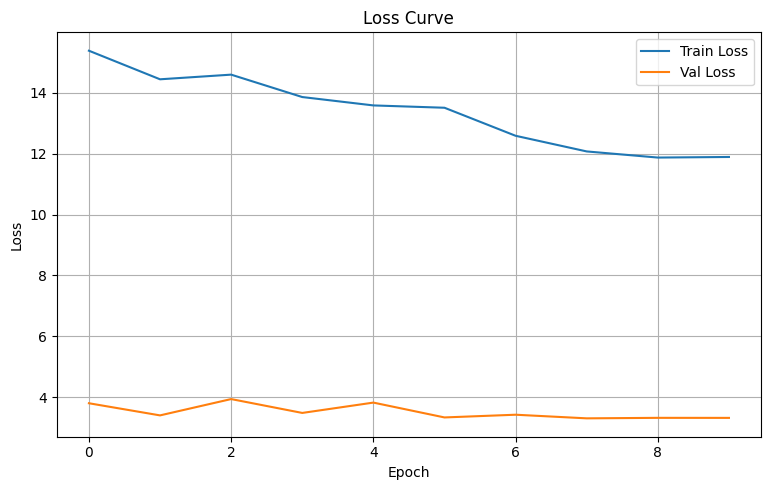

In [20]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


In [19]:
model.eval()
test_rmse_total = 0
test_mae_total = 0
d1_total, d2_total, d3_total = 0, 0, 0
num_batches = 0

with torch.no_grad():
    for images, targets_log, _, _ in test_loader:
        images, targets_log = images.to(device).float(), targets_log.to(device).float()
        outputs_log = model(images)[0]
        outputs_log = F.interpolate(outputs_log, size=targets_log.shape[2:], mode='bilinear', align_corners=True)
        outputs_log = torch.clamp(outputs_log, min=0.0, max=5.3)
        
        targets = torch.expm1(targets_log)
        outputs = torch.expm1(outputs_log)
        outputs = torch.where(outputs < 2.5, torch.tensor(0.0, device=outputs.device), outputs)
        
        rmse = torch.sqrt(F.mse_loss(outputs, targets)).item()
        mae = torch.mean(torch.abs(outputs - targets)).item()
        test_rmse_total += rmse
        test_mae_total += mae

        d1, d2, d3 = compute_delta_metrics(outputs, targets)
        d1_total += d1
        d2_total += d2
        d3_total += d3

        num_batches += 1

avg_test_rmse = test_rmse_total / num_batches
avg_test_mae = test_mae_total / num_batches
avg_d1 = d1_total / num_batches
avg_d2 = d2_total / num_batches
avg_d3 = d3_total / num_batches

print(f"🧪 Final Test RMSE: {avg_test_rmse:.4f} | MAE: {avg_test_mae:.4f}")
print(f"📏 Final Test δ Metrics — δ₁: {avg_d1:.4f} | δ₂: {avg_d2:.4f} | δ₃: {avg_d3:.4f}")


🧪 Final Test RMSE: 6.8623 | MAE: 3.4793
📏 Final Test δ Metrics — δ₁: 0.6440 | δ₂: 0.6885 | δ₃: 0.7251



Sample 0:
  GT DSM Min: 0.0, Max: 38.574424743652344
  Pred DSM Min: 0.0, Max: 31.673337936401367

Sample 1:
  GT DSM Min: 0.0, Max: 34.20183181762695
  Pred DSM Min: 0.0, Max: 20.74939727783203


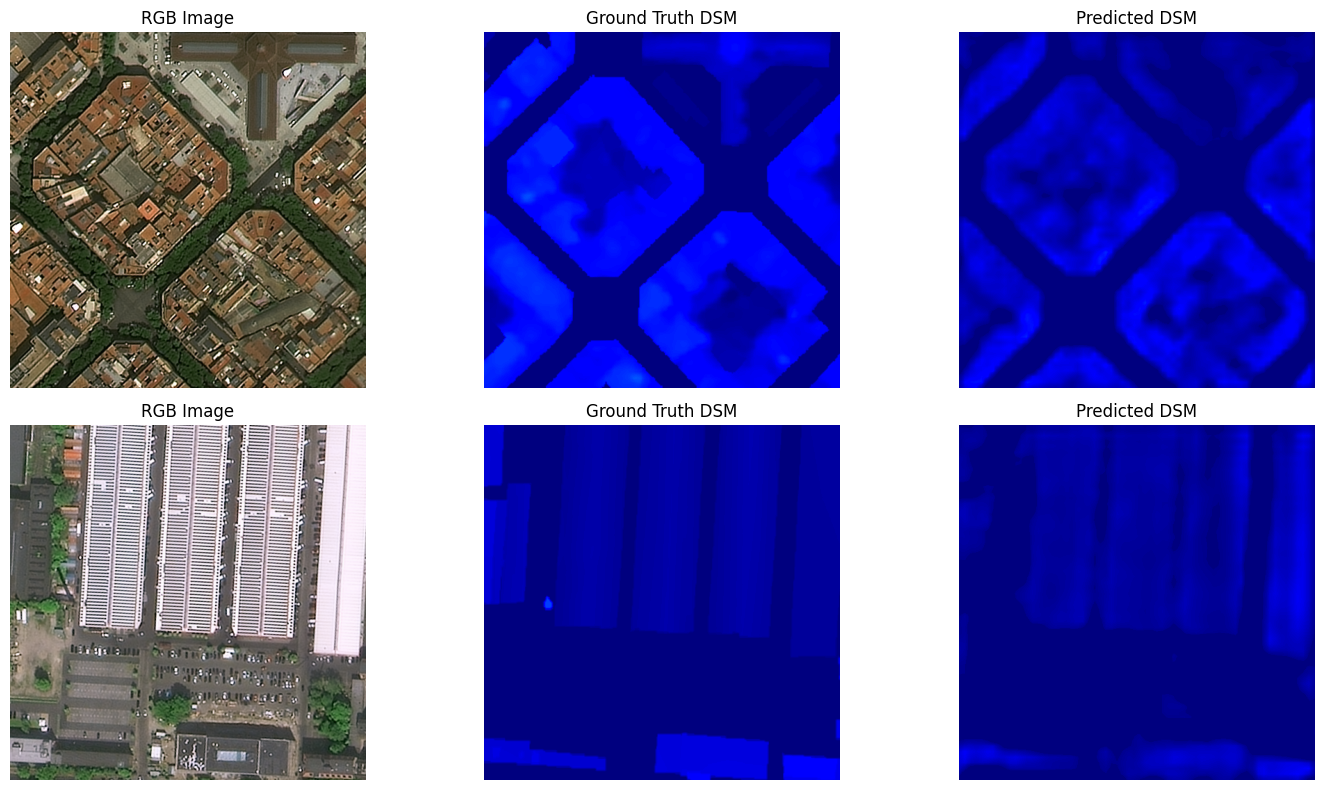

In [22]:
model.eval()


images, targets_log, _, _ = next(iter(test_loader))
images = images.to(device).float()

targets = torch.expm1(targets_log)

with torch.no_grad():
    outputs_log = model(images)[0]
    outputs_log = F.interpolate(outputs_log,size=targets_log.shape[2:],mode='bilinear',align_corners=True)
    outputs_log = torch.clamp(outputs_log, min=0.0, max=5.3)

outputs = torch.expm1(outputs_log)
outputs = torch.where(outputs < 2.5, torch.tensor(0.0, device=outputs.device), outputs)

images = images.cpu().numpy()
targets = targets.cpu().numpy()
outputs = outputs.cpu().numpy()

num_samples = min(4, images.shape[0])
plt.figure(figsize=(15, num_samples * 4))

for i in range(num_samples):
    print(f"\nSample {i}:")
    print(f"  GT DSM Min: {targets[i][0].min()}, Max: {targets[i][0].max()}")
    print(f"  Pred DSM Min: {outputs[i][0].min()}, Max: {outputs[i][0].max()}")

for i in range(num_samples):

    plt.subplot(num_samples, 3, i * 3 + 1)
    rgb = images[i][:3, :, :]
    rgb = rgb.transpose(1, 2, 0)

    rgb += np.array([128, 128, 128])     
    rgb = np.clip(rgb, 0, 255).astype(np.uint8)
    plt.imshow(rgb)
    plt.title("RGB Image")
    plt.axis('off')

    plt.subplot(num_samples, 3, i * 3 + 2)
    gt_dsm = targets[i][0]
    plt.imshow(gt_dsm, cmap='jet', vmin=0, vmax=184)
    plt.title("Ground Truth DSM")
    plt.axis('off')
    
    plt.subplot(num_samples, 3, i * 3 + 3)
    pred_dsm = outputs[i][0]
    plt.imshow(pred_dsm, cmap='jet', vmin=0, vmax=184)
    plt.title("Predicted DSM")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Changes made

### Dataset:

DSM data is now log-normalized. During inference, we scale both target values and outputs both up. We use log1p (log(1+x)) for log normalization and expm1 to reverse to deal with log(0) scenarios. 

SAR data is also log normalized and mean centralized now.

### Architecture changes: 

We now have two heads, one for the regression branch, and one for the classification branch. The prior process upto and including passing the outputs from the ResNet layers to the ASPP module are the same. After, the features are passed into two different heads. The first one (classification) takes the output of the ASPP layer and returns likelihoods for 4 bins following HGD's implementation:
- Ground - 0 to 2.5 meters
- Low - 2.5 to 10 meters
- Medium - 10 to 36 meters
- High - 36 meters +

We use cross entropy loss on the outputs, add that to the regression loss to guide that branch. The formula used is:
- total_loss = 5 * CE_Loss + 30 * SmoothL1Loss

Again, same as in HGDNet, giving preference to reducing loss from the regression branch, which is eventually the one we'll be using for inference.

### Results:

The results are very promising. Although RMSE and MAE have increased, delta values have also increased significantly.
- Final Test RMSE: 6.8623 | MAE: 3.4793
- Final Test δ Metrics — δ₁: 0.6440 | δ₂: 0.6885 | δ₃: 0.7251

### Future plans: 

Multiple things we could try. HGDNet tried experimenting with different combos for layers, we could try swapping out ASPP for PSP (we tried that earlier too but ASPP proved superior back in first improvement). We could try using ConvNext-V2 for the backbone instead of Resnet. I personally want to explore how vision transformers can be incorporated into this - using height heirarchical guided layout coupled with VITs would surely bring improvements given how VITs excel in taking in global cues, which are incredibly important for building height estimation. The issue with that is that VITs require large amounts of data, and we have 1200 something images in our training dataset, with a batch size of 2 they already take 6+ minutes per epoch. For a larger datast with an even heavier model, the compute power required would be outside our scope. We'll need to figure something out - to be discussed further if possible :D (sproj dedo).
